In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost
!pip install category_encoders
!pip install eli5
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 758 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 32.3 MB/s 
     |████████████████████████████████| 133 kB 59.0 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=71727edc93dc2ac0b36223b41b9033829d55558abfd3b184bf110657653d69b7
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score
import eli5
from eli5.sklearn import PermutationImportance
import shap

In [ ]:
def plot_target_ratio_by_continuous_features(df:pd.DataFrame, target:str, features:list, num_cols=1,  num_cuts=5, size:tuple=(12, 18)):
    '''
    연속형 피처에서, 연속값 피처를 N개 구간으로 나눠 이산형으로 표현하여 타깃값 비율을 그리는 함수
    '''
    df_copy = df.copy()
    
    mpl.rc('font', size=9)
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(math.ceil(len(features)/num_cols), num_cols)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for idx, feature in enumerate(features):
        df_copy[feature] = pd.cut(df_copy[feature], num_cuts)
        ax = plt.subplot(grid[idx])
        sns.barplot(x=feature, y=target, data=df_copy, ax=ax, palette='Set2')
        ax.tick_params(axis='x', labelrotation=10)


def corr_heatmap(df:pd.DataFrame, features:list, size:tuple=(10, 8)):
    '''
    연속형 피처의 상관관계를 히트맵으로 나타냅니다
    '''
    df_copy = df.copy()
    
    plt.figure(figsize=size)
    cont_corr = df_copy.dropna()[features].corr()
    sns.heatmap(cont_corr, annot=True, cmap='OrRd')


def resumetable(df=pd.DataFrame): #보고서 형식으로 데이터를 파악하는 함수
    
    print(f'데이터세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    
    return summary


## 막대그래프 비율 표시
def mark_percent(ax, df:pd.DataFrame):
    '''
    seaborn 막대그래프에서, 각 도형 상단에 비율을 표시합니다
    '''
    total_size = len(df)
    
    for patch in ax.patches:
        h = patch.get_height()
        w = patch.get_width()
        left_coord = patch.get_x()
        percent = h / total_size * 100
        
        ax.text(left_coord + w/2,
                h + total_size*0.001,
                '{:1.1f}%'.format(percent),
                ha='center')
        

def draw_distribution(df, type='hist'):
  mpl.rc('font', size=15)
  if type == 'hist':
    ax = df.hist();
  elif type == 'count':
    ax = df.value_counts().plot.bar();
  plt.title(f'Distribution of {df.name}')
  plt.xlabel(df.name)

  if type == 'count':
    mark_percent(ax, df)
  plt.show()


def kde_mean_plot(df, feature:list=None):
  if feature != None:
    for col in feature:
      plt.figure(figsize=(10, 6))
      mpl.rc('font', size=15)
      sns.kdeplot(x=col, data=df, hue='fetal_health', palette='deep', shade=True, bw=0.2);
      plt.axvline(df_1[col].mean(), color='#4e648a')
      plt.axvline(df_2[col].mean(), color='#97694f')
      plt.axvline(df_3[col].mean(), color='#54845f')
      plt.title(f'kdeplot of {col}')
      plt.show()
  else:
    for col in df.columns:
      plt.figure(figsize=(10, 6))
      mpl.rc('font', size=15)
      sns.kdeplot(x=col, data=df, hue='fetal_health', palette='deep', shade=True, bw=0.2);
      plt.axvline(df_1[col].mean(), color='#4e648a')
      plt.axvline(df_2[col].mean(), color='#97694f')
      plt.axvline(df_3[col].mean(), color='#54845f')
      plt.title(f'kdeplot of {col}')
      plt.show()

  
def anova(df):
  for col in df.columns:
    anova = stats.f_oneway(df[df['fetal_health']==1][col],
                           df[df['fetal_health']==2][col],
                           df[df['fetal_health']==3][col])
    
    ttest_12 = stats.ttest_ind(df[df['fetal_health']==1][col],
                               df[df['fetal_health']==2][col], equal_var=False)
    
    ttest_23 = stats.ttest_ind(df[df['fetal_health']==2][col],
                               df[df['fetal_health']==3][col], equal_var=False)
    
    ttest_31 = stats.ttest_ind(df[df['fetal_health']==3][col],
                               df[df['fetal_health']==1][col], equal_var=False)
    
    print(col)
    print(f'ANOVA:{anova[1]}')
    print(f'ttest_12:{ttest_12[1]}')
    print(f'ttest_23:{ttest_23[1]}')
    print(f'ttest_31:{ttest_31[1]}')
    print()



def get_permutation_importance(X, y, estimator, scoring:'str'='accuracy', num_show:int=None):
  '''
  permutation importance를 시각화하는 함수
  X : 전처리/인코딩 이 완료된 X_valid
  y : 전처리/인코딩 등이 완료된 y_valid
  estimator : 학습된 ML model
  scoring : 검증 기준
  '''

  permuter = PermutationImportance(
      estimator = estimator,
      scoring = scoring, # metric
      n_iter = 5
  )

  permuter.fit(X, y)

  eli5.show_weights(
      permuter, 
      top=None,
      feature_names=X.columns.tolist() # list 형식으로 넣어야 합니다
  )

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/challenge/fetus/fetus_health.csv')

In [ ]:
df.rename(columns={'baseline value':'baseline_value'}, inplace=True)

In [ ]:
xgb = XGBClassifier(random_state=2077)

In [ ]:
X = df.drop(columns=['fetal_health'])
y = df['fetal_health']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=2077)

In [ ]:
xgb.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob', random_state=2077)

In [ ]:
f1_score(y_test, xgb.predict(X_test), average='weighted')

0.9363354524386145

In [ ]:
permuter = PermutationImportance(
    estimator = xgb
)

permuter.fit(X_test, y_test)

eli5.show_weights(
    permuter,
    feature_names=X_test.columns.tolist(),
    top=None
)

Weight,Feature
0.0737 ± 0.0049,abnormal_short_term_variability
0.0408 ± 0.0130,accelerations
0.0376 ± 0.0086,percentage_of_time_with_abnormal_long_term_variability
0.0307 ± 0.0070,histogram_mean
0.0147 ± 0.0065,uterine_contractions
0.0138 ± 0.0046,mean_value_of_short_term_variability
0.0103 ± 0.0051,prolongued_decelerations
0.0034 ± 0.0023,light_decelerations
0.0025 ± 0.0065,histogram_mode
0.0022 ± 0.0043,histogram_median


In [ ]:
from sklearn.feature_selection import SelectKBest #Feature Selector
from sklearn.feature_selection import f_classif #F-ratio statistic for categorical values

In [ ]:
#Feature Selection
X=df.drop(['fetal_health'], axis=1)
y=df['fetal_health']
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns

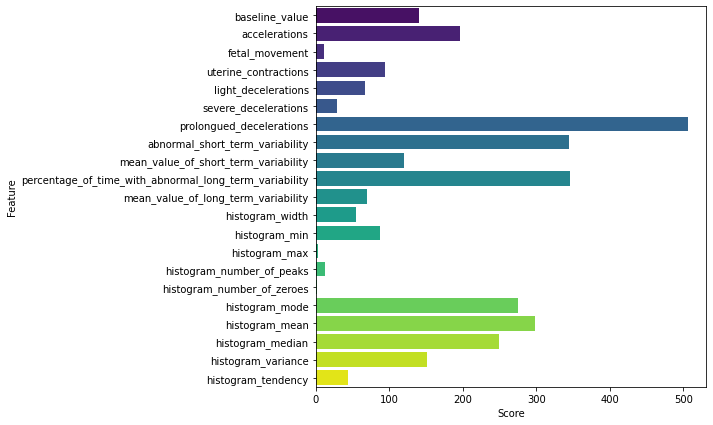

In [ ]:
#Visualize the feature scores
fig, ax=plt.subplots(figsize=(7,7))
plot=sns.barplot(data=featureScores, x='Score', y='Feature', palette='viridis',linewidth=0.5, saturation=2, orient='h')
plot

In [ ]:
df.columns

Index(['baseline_value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

In [ ]:
#Selection method
selected_features = ['accelerations', 'prolongued_decelerations', 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability','histogram_mode', 'histogram_mean', 'histogram_median', 'baseline_value', 'fetal_movement', 'uterine_contractions', 'histogram_variance']

In [ ]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
xgb.fit(X_train_selected, y_train)

XGBClassifier(objective='multi:softprob', random_state=2077)

In [ ]:
f1_score(y_test, xgb.predict(X_test_selected), average='weighted')

0.9432220319508502

In [ ]:
permuter = PermutationImportance(
    estimator = xgb
)

permuter.fit(X_test_selected, y_test)

eli5.show_weights(
    permuter,
    feature_names=X_test_selected.columns.tolist(),
    top=None
)

Weight,Feature
0.0959 ± 0.0134,abnormal_short_term_variability
0.0530 ± 0.0085,percentage_of_time_with_abnormal_long_term_variability
0.0511 ± 0.0209,accelerations
0.0408 ± 0.0105,histogram_mean
0.0295 ± 0.0054,uterine_contractions
0.0129 ± 0.0031,histogram_median
0.0113 ± 0.0070,prolongued_decelerations
0.0107 ± 0.0073,baseline_value
0.0091 ± 0.0042,histogram_mode
0.0075 ± 0.0064,histogram_variance


In [ ]:
#Selection method
selected_features = ['accelerations', 'prolongued_decelerations', 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability','histogram_mode', 'histogram_mean', 'histogram_median', 'baseline_value', 'fetal_movement', 'uterine_contractions']

In [ ]:
xgb = XGBClassifier(objective='multi:softmax',
                    early_stopping_rounds=50,
                    eval_set=[(X_test_selected, y_test)],
                    eval_matrix='auc',
                    learning_rate=0.2,
                    max_depth=5,
                    n_estimators=150
                    )

xgb.fit(X_train_selected, y_train)

XGBClassifier(early_stopping_rounds=50, eval_matrix='auc',
              eval_set=[(      accelerations  prolongued_decelerations  \
1199          0.005                       0.0   
1764          0.000                       0.0   
734           0.009                       0.0   
1042          0.000                       0.0   
175           0.005                       0.0   
...             ...                       ...   
77            0.007                       0.0   
735           0.010                       0.0   
705           0.000                       0.0   
967           0.005                       0.0   
654           0.000                       0.0   

      abnormal_short_term_variability  \
1199                             44.0   
1764                             60.0   
734                              44.0   
1042                             37.0   
175                              31.0   
...                               ...   
77                               36.0   

In [ ]:
f1_score(y_test, xgb.predict(X_test_selected), average='weighted')

0.9565611258557032

In [ ]:
print(confusion_matrix(y_test, xgb.predict(X_test_selected)))

[[491   5   1]
 [ 17  70   1]
 [  1   2  50]]


In [ ]:
print(classification_report(y_test, xgb.predict(X_test_selected), target_names = ['normal', 'suspect', 'pathological']))

              precision    recall  f1-score   support

      normal       0.96      0.99      0.98       497
     suspect       0.91      0.80      0.85        88
pathological       0.96      0.94      0.95        53

    accuracy                           0.96       638
   macro avg       0.95      0.91      0.93       638
weighted avg       0.96      0.96      0.96       638



In [ ]:
recall = recall_score(y_test,
             xgb.predict(X_test_selected),
             average='weighted')

print(f'위양성률 : {(1-recall) * 100}')

위양성률 : 4.2319749216300995


In [ ]:
permuter = PermutationImportance(
    estimator = xgb
)

permuter.fit(X_test_selected, y_test)

eli5.show_weights(
    permuter,
    feature_names=X_test_selected.columns.tolist(),
    top=None
)

Weight,Feature
0.1082 ± 0.0124,abnormal_short_term_variability
0.0687 ± 0.0111,accelerations
0.0502 ± 0.0099,percentage_of_time_with_abnormal_long_term_variability
0.0426 ± 0.0104,histogram_mean
0.0276 ± 0.0102,uterine_contractions
0.0248 ± 0.0046,histogram_mode
0.0141 ± 0.0034,histogram_median
0.0135 ± 0.0051,baseline_value
0.0132 ± 0.0098,prolongued_decelerations
0.0113 ± 0.0042,histogram_variance


In [ ]:
def draw_shap(estimator, df):
  '''
  shap 그래프를 그립니다
  estimator : 훈련된 ML model
  '''

  shap_df = df

  # 예측
  pred = estimator.predict(shap_df)

  # Shap value를 계산합니다
  explainer = shap.TreeExplainer(estimator)
  shap_values = explainer.shap_values(shap_df)

  # Shap value, 특성이름, 특성값을 가지는 Series를 만듭니다
  feature_names = shap_df.columns
  feature_values = shap_df.values
  shaps = pd.Series(shap_values, zip(feature_names, feature_values))

  # 결과를 프린트 합니다.
  result = f'평균가격: ${explainer.expected_value[0]:,.0f} \n'
  result += f'예측가격: ${pred:,.0f}. \n'
  result += shaps.to_string()
  print(result)

  # SHAP Force Plot
  shap.initjs()
  return shap.force_plot(
      base_value=explainer.expected_value, 
      shap_values=shap_values, 
      features=shap_df
  )

In [ ]:
drop_list = ['histogram_max', 'histogram_number_of_zeroes']
X_train_dropped = X_train.drop(columns=drop_list)
X_test_dropped = X_test.drop(columns=drop_list)

xgb_d = XGBClassifier(objective='multi:softmax',
                    early_stopping_rounds=50,
                    eval_set=[(X_test_selected, y_test)],
                    eval_matrix='auc',
                    learning_rate=0.2,
                    max_depth=5,
                    n_estimators=150,
                    random_state=2077
                    )

xgb_d.fit(X_train_dropped, y_train)


XGBClassifier(early_stopping_rounds=50, eval_matrix='auc',
              eval_set=[(      accelerations  prolongued_decelerations  \
1199          0.005                       0.0   
1764          0.000                       0.0   
734           0.009                       0.0   
1042          0.000                       0.0   
175           0.005                       0.0   
...             ...                       ...   
77            0.007                       0.0   
735           0.010                       0.0   
705           0.000                       0.0   
967           0.005                       0.0   
654           0.000                       0.0   

      abnormal_short_term_variability  \
1199                             44.0   
1764                             60.0   
734                              44.0   
1042                             37.0   
175                              31.0   
...                               ...   
77                               36.0   

In [ ]:
f1_score(y_test, xgb_d.predict(X_test_dropped), average='weighted')

0.9381289831094034

In [ ]:
f1_score(y_test, xgb_d.predict(X_test_dropped), average='weighted')

0.9516082762884169